# Classification models.

In this notebook, 3 classification models will be built for predicting the kind of iris flower from their atributes. This models will be used from the Scikit-Learn library, and some techiques like cross validation will be implemented in case of overfitting.

Finally, a brief comparison will be made between these models, in order to select the better option and compare it in the final notebook with a Multi Layer Perceptron Model.
 

In [124]:
__author__ = "Víctor Vega Sobral"

In [125]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import learning_curve

from scipy.stats import uniform
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
import joblib

### Import Iris Normalized Data

In [126]:
iris_df = pd.read_csv("datasets/iris_normalized_data.csv")

# Eliminating the first column, with no significant data
iris_df.drop(iris_df.columns[0], axis=1, inplace=True)
iris_df.head()


,sepal_length,sepal_width,petal_length,petal_width,class
0,-0.900681,1.032057,-1.341272,-1.312977,0
1,-1.143017,-0.124958,-1.341272,-1.312977,0
2,-1.385353,0.337848,-1.398138,-1.312977,0
3,-1.506521,0.106445,-1.284407,-1.312977,0
4,-1.021849,1.263460,-1.341272,-1.312977,0


### Data Split

- Train set: 70% of the dataset.
- Dev set: 15% of the dataset.
- Test set: 15% of the dataset.

For this, we need to first split the data into 85/15, for training+dev/test.

Then, we split the remaining 85 into 70/15, for having 70% for the train set and 15 for the dev set.

We didn´t use a dev set in the previous subjects. However, in **the Deep Learning Specialization by Coursera that I´m doing, Andrew Ng explains the importance of having a dev set**.

Dev set is separated from training and test set, and it´s commonly used to:
- Adjust hyperparameters. 
- Evaluate the model´s performance before the final test. 
- Useful for avoiding possible overfitting and selecting the best model.
- Taking possible decissions about model´s generalization just before the final test.
- Avoiding bias in the evaluation due to the continous usage of test set for validating.

Therefore, the workflow will be the next one:

1. Training and evaluating the models in ``dev`` set. The model with best precission will be the suitable for test set.
    - Train with ``training`` set.
    - Evaluate in ``dev`` set.
    - Create a `csv file` for every set, in order to make possible loading them in other notebooks. 


2. Hyperparameter tuning in `dev` set.
    - If dev set results aren´t good.
    - Avoiding overfitting with **cross-validation techniques** like `GridSearchCV` and `RandomizedSearchCV`.
    - Finally, we re-evaluate the tuned model in dev before passing it to test.

3. **In the next Notebook**:
    - Implement MLP and evaluating it in dev set.
    - Compare its performance with the best traditional model.
    - If MLP is better than the other model, we finally pass this one to the test set.








In [127]:
X = iris_df.drop('class', axis = 1) # Caracteristicas
y = iris_df['class']

# División estratificada
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp,  
    random_state=42
)
# Storing the sets in separate csvs

X_train.to_csv("datasets/iris_data_splits/x_train.csv", index=False)
y_train.to_csv("datasets/iris_data_splits/y_train.csv", index=False)
X_dev.to_csv("datasets/iris_data_splits/x_dev.csv", index=False)
y_dev.to_csv("datasets/iris_data_splits/y_dev.csv", index=False)
X_test.to_csv("datasets/iris_data_splits/x_test.csv", index=False)
y_test.to_csv("datasets/iris_data_splits/y_test.csv", index=False)

target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# Final split proportions:
# Train: 70% 
# Dev: 15% 
# Test: 15%


In [128]:
# Model 1: Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_dev_pred = log_reg.predict(X_dev)

print("Classification Report (Logistic Regression):")
print(classification_report(y_dev, log_reg_dev_pred, target_names=target_names))

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.75      0.86      0.80         7
 Iris-virginica       0.83      0.71      0.77         7

       accuracy                           0.86        22
      macro avg       0.86      0.86      0.86        22
   weighted avg       0.87      0.86      0.86        22



In [129]:
# Model 2: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_dev_pred = rf.predict(X_dev)


print("Classification Report (Random Forest):")
print(classification_report(y_dev, rf_dev_pred, target_names=target_names))


Classification Report (Random Forest):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.75      0.86      0.80         7
 Iris-virginica       0.83      0.71      0.77         7

       accuracy                           0.86        22
      macro avg       0.86      0.86      0.86        22
   weighted avg       0.87      0.86      0.86        22



In [130]:
# Model 3: SVC
svc = SVC()
svc.fit(X_train, y_train)
svc_dev_pred = svc.predict(X_dev)
print("Classification Report (SVC):")
print(classification_report(y_dev, log_reg_dev_pred, target_names=target_names))

Classification Report (SVC):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.75      0.86      0.80         7
 Iris-virginica       0.83      0.71      0.77         7

       accuracy                           0.86        22
      macro avg       0.86      0.86      0.86        22
   weighted avg       0.87      0.86      0.86        22



#### Possible overfitting.

- Plotting the difference between how the model learn the traning and dev data.
- If there are signs of overfitting, apply cross-validation to the models.

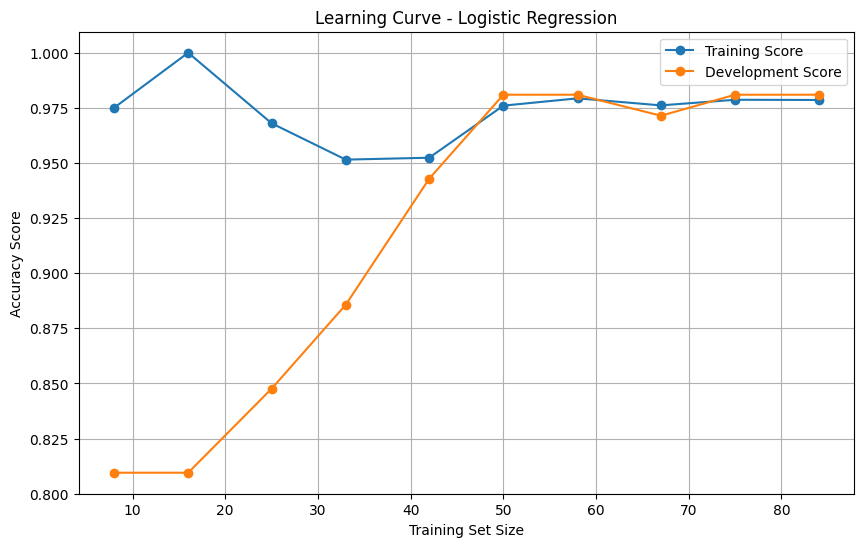

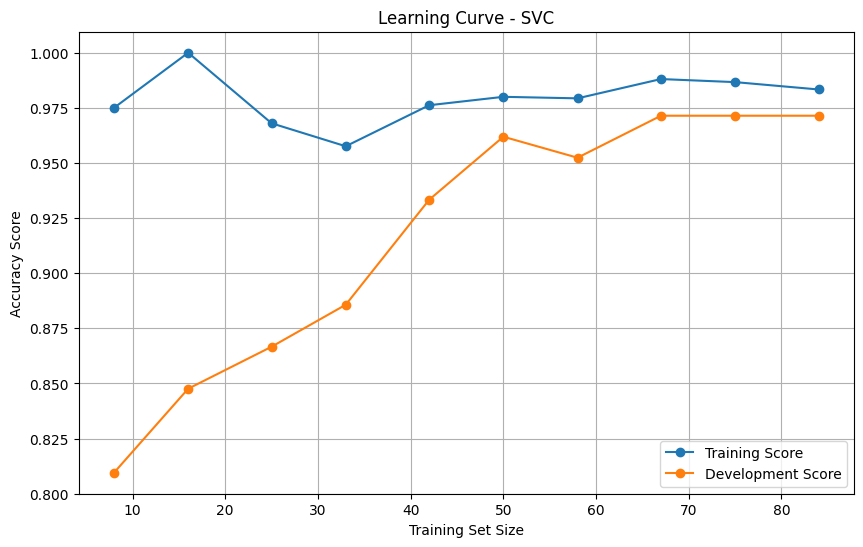

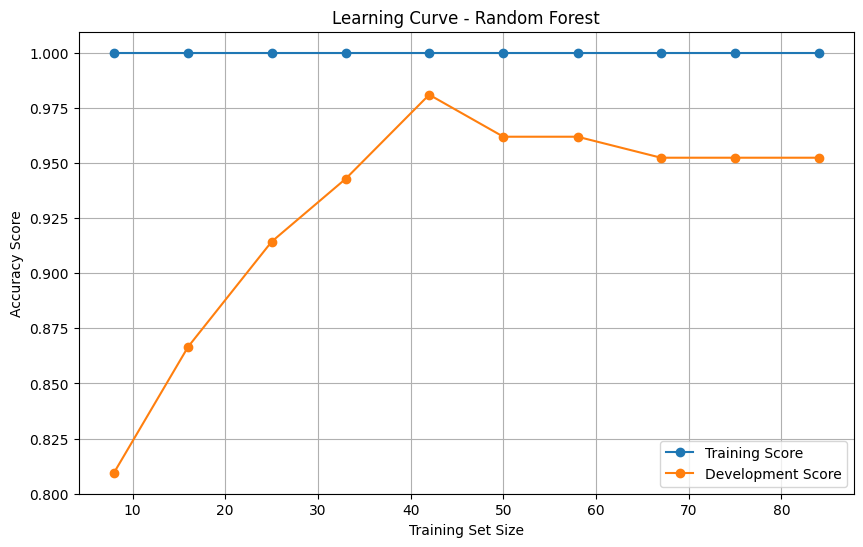

In [131]:


def plot_learning_curve(model, X_train, y_train, title):
    train_sizes, train_scores, dev_scores = learning_curve(
        model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # Calcular medias y desviaciones estándar
    train_mean = np.mean(train_scores, axis=1)
    dev_mean = np.mean(dev_scores, axis=1)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, dev_mean, 'o-', label='Development Score')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar curvas con validación cruzada (cv=5)
plot_learning_curve(log_reg, X_train, y_train, "Logistic Regression")
plot_learning_curve(svc, X_train, y_train, "SVC")
plot_learning_curve(rf, X_train, y_train, "Random Forest")

### Graph Conclussions

The 3 models start with an important score in the training set, converging very fast to almost 100. This problem is clear in Random Forest, where it starts in 100. Therefore, due to the difference between the dev and traning scores, `cross-validation` will be implemented, due to **clear signs of overfitting**.

Moreover, all 

### Function for creating and optimizing the models

In [132]:
def optimize_and_plot(model, param_grid, X_train, y_train, X_dev, y_dev, model_name):
    # Optimizar hiperparámetros con GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_
    
    # Calcular métricas con el mejor modelo
    y_pred = best_model.predict(X_dev)
    
    
    print(f"Classification Report ({model_name}):")
    print(classification_report(y_dev, y_pred, target_names=target_names))
    # Generar curva de aprendizaje del modelo optimizado
    plot_learning_curve(best_model, X_train, y_train, f"{model_name} (Optimized)")
    
    return best_model






### Parameters for optimizing in each model

#### Logistic Regression

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.75      0.86      0.80         7
 Iris-virginica       0.83      0.71      0.77         7

       accuracy                           0.86        22
      macro avg       0.86      0.86      0.86        22
   weighted avg       0.87      0.86      0.86        22



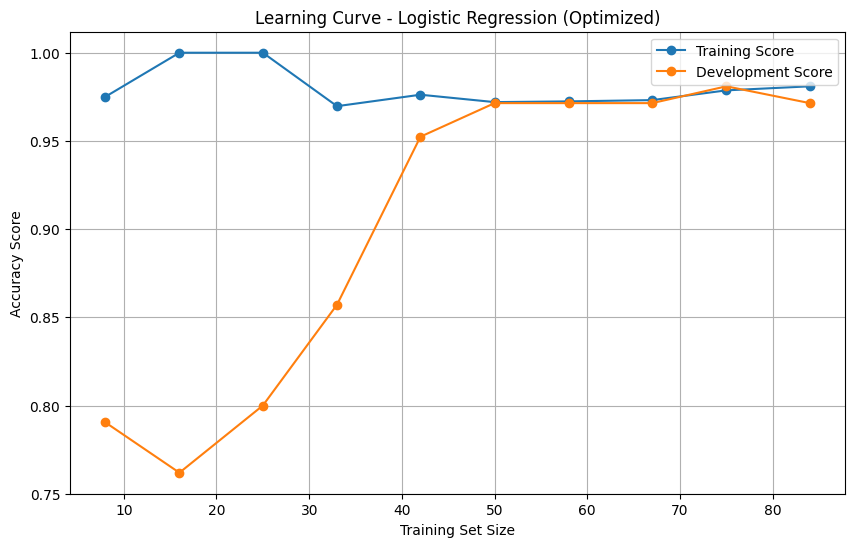

In [133]:
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

optimized_log_reg = optimize_and_plot(
    LogisticRegression(), 
    log_reg_params, 
    X_train, y_train, X_dev, y_dev, 
    "Logistic Regression"
)

#### Random Forest

Classification Report (Random Forest):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.86      0.86      0.86         7
 Iris-virginica       0.86      0.86      0.86         7

       accuracy                           0.91        22
      macro avg       0.90      0.90      0.90        22
   weighted avg       0.91      0.91      0.91        22



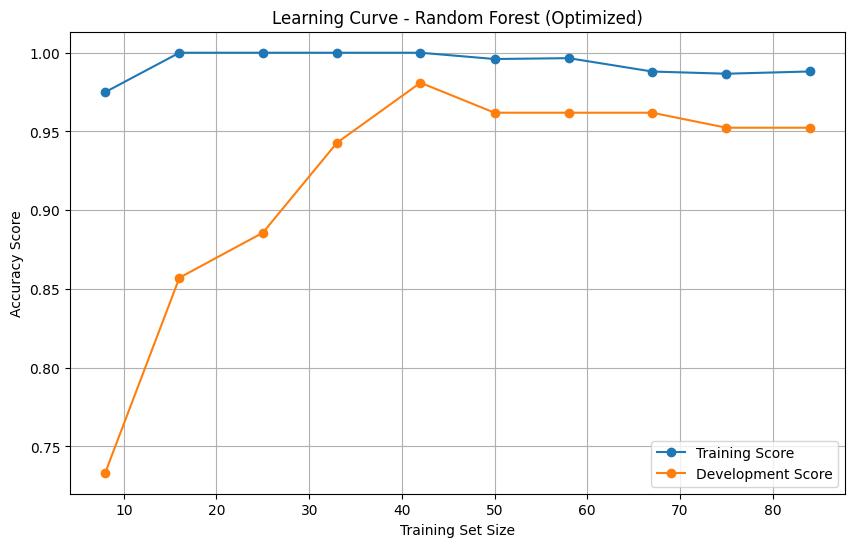

In [134]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

optimized_rf = optimize_and_plot(
    RandomForestClassifier(), 
    rf_params, 
    X_train, y_train, X_dev, y_dev, 
    "Random Forest"
)

#### SVC

Classification Report (SVC):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       0.75      0.86      0.80         7
 Iris-virginica       0.83      0.71      0.77         7

       accuracy                           0.86        22
      macro avg       0.86      0.86      0.86        22
   weighted avg       0.87      0.86      0.86        22



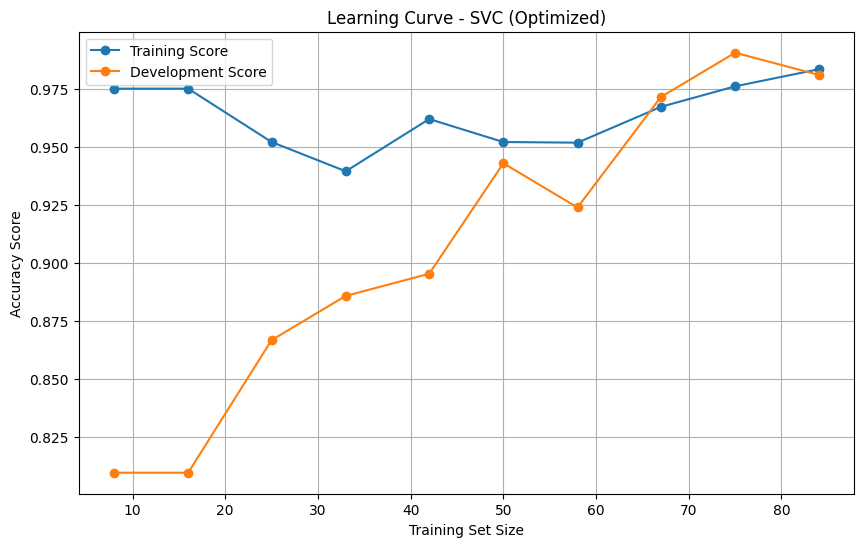

In [135]:
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 1]
}

optimized_svc = optimize_and_plot(
    SVC(), 
    svc_params, 
    X_train, y_train, X_dev, y_dev, 
    "SVC"
)

## Conclussions and best model

`RandomForest` is the best model looking at the metrics and after applying cross-validation, overfitting seems to have been fixed. However, the extremelly high values on the training set when applying the learning curve are still very high.

Therefore, I´ll pass RandomForest to the traning set to see how it works with new data. The high values of the traning data should be taken into consideration in a deeper investigation about which of the 3 models is the best one, but for the purposes of this assignment, I´ll pass to the next step.

In [139]:
# Get predictions on test set using optimized Random Forest
rf_test_pred = optimized_rf.predict(X_test)

# Print classification report
print("Classification Report (Random Forest - Test Set):")
print(classification_report(y_test, rf_test_pred, target_names=target_names))

Classification Report (Random Forest - Test Set):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.89      1.00      0.94         8
 Iris-virginica       1.00      0.88      0.93         8

       accuracy                           0.96        23
      macro avg       0.96      0.96      0.96        23
   weighted avg       0.96      0.96      0.96        23



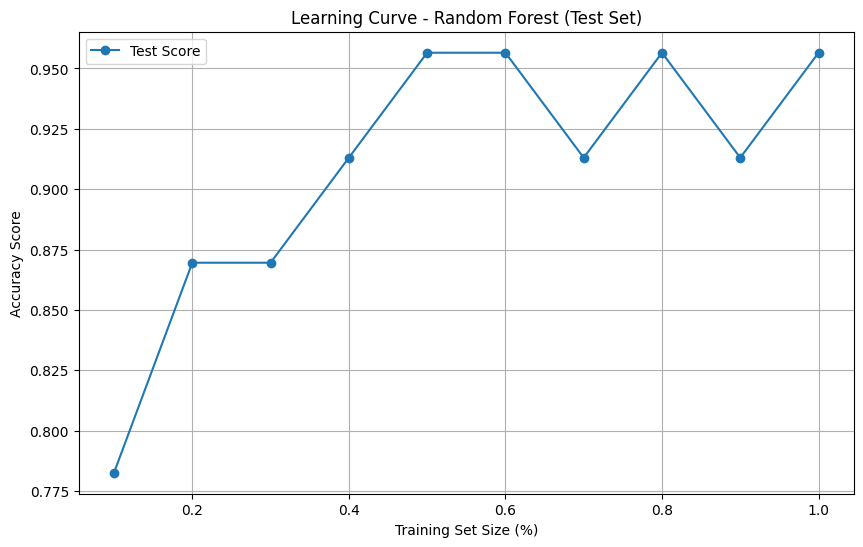

In [143]:
# Simplified learning curve plot
test_scores = []
sizes = np.linspace(0.1, 1.0, 10)

for size in sizes:
    n_samples = int(len(X_train) * size)
    optimized_rf.fit(X_train[:n_samples], y_train[:n_samples])
    test_scores.append(optimized_rf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(sizes, test_scores, 'o-', label='Test Score')
plt.title('Learning Curve - Random Forest (Test Set)')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

## Persistance of the model

Finally, it´s necessary to persist this model for being able to charge it in the next notebook and comparing its performance with the MLP.


In [144]:
from pathlib import Path

# Create models directory if it doesn't exist
Path('models').mkdir(exist_ok=True)

# Save optimized Random Forest model
joblib.dump(optimized_rf, 'models/optimized_random_forest.joblib')

# Quick load test to verify
loaded_model = joblib.load('models/optimized_random_forest.joblib')
print(f"Model saved successfully. Test accuracy: {loaded_model.score(X_test, y_test):.4f}")

Model saved successfully. Test accuracy: 0.9565
